In [1]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [3]:
client = bigquery.Client(project='subugoe-collaborative')

/opt/homebrew/Cellar/jupyterlab/4.0.9/libexec/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
openalex = '`subugoe-collaborative.openalex.works`'
s2 = '`subugoe-wag-closed.S2AG.papers_2023_09_26`'
pm = '`subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022`'

In [9]:
pubmed_type_mapping = {
    'erratum': ['Published Erratum', 'Retraction of Publication', 'Retracted Publication'],
    'editorial': ['Editorial'],
    'news': ['News'],
    'letter': ['Letter'],
    'review': ['Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review'],
    'article': ['Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article'],
    'funding_info': ['Research Support, Non-U.S. Gov''t', 'Research Support, N.I.H., Extramural', 'Research Support, U.S. Gov''t, Non-P.H.S.', 'Research Support, U.S. Gov''t, P.H.S.',
                    'Research Support, N.I.H., Intramural', 'Research Support, American Recovery and Reinvestment Act'],
    'other': ['Comment', 'Comparative Study', 'Multicenter Study', 'English Abstract', 'Observational Study']
}

In [7]:
openalex_pubtypes = client.query(f"""
                                  SELECT type AS pubtype, COUNT(DISTINCT(doi)) AS n
                                  FROM {openalex}  
                                  GROUP BY pubtype
                                  ORDER BY n DESC
                                  """).to_dataframe()

In [8]:
openalex_pubtypes

,pubtype,n
0,article,118000279
1,book-chapter,20235766
2,dataset,3072143
3,paratext,2684944
4,book,1855468
5,other,1140985
6,reference-entry,1019547
7,dissertation,929041
8,report,771379
9,peer-review,416768


In [7]:
pm_pubtypes = client.query(f"""
                            SELECT ptype AS pm_pubtypes, COUNT(DISTINCT(doi)) AS n
                            FROM {pm} AS pm
                            GROUP BY pm_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [8]:
pm_pubtypes

,pm_pubtypes,n
0,Journal Article,18041945
1,"Research Support, Non-U.S. Gov''t",5843529
2,Review,1970486
3,"Research Support, N.I.H., Extramural",1352844
4,Case Reports,1069817
...,...,...
74,Periodical Index,23
75,Legislation,21
76,None,15
77,Scientific Integrity Review,8


In [102]:
openalex_pm_pubtypes = client.query(f"""
                                    SELECT type AS oalex_type, ptype AS pm_pubtypes, COUNT(DISTINCT(oalex.doi)) AS n
                                    FROM {pm} AS pm
                                    JOIN {openalex} AS oalex
                                    ON LOWER(oalex.doi) = LOWER(pm.doi)
                                    GROUP BY oalex_type, pm_pubtypes
                                    ORDER BY oalex_type, pm_pubtypes
                                    """).to_dataframe()

In [103]:
openalex_pm_pubtypes

,oalex_type,pm_pubtypes,n
0,article,None,15
1,article,Adaptive Clinical Trial,37
2,article,Address,2872
3,article,Autobiography,1872
4,article,Bibliography,2548
...,...,...,...
359,report,"Research Support, N.I.H., Extramural",3
360,report,"Research Support, Non-U.S. Gov''t",3
361,report,"Research Support, U.S. Gov''t, Non-P.H.S.",2
362,report,Review,14


In [104]:
openalex_pm_pubtypes.fillna('None', inplace=True)

In [105]:
d = {}
for row in openalex_pm_pubtypes.to_dict('records'):
    oalex_type = row['oalex_type']
    pm_pubtype = row['pm_pubtypes']
    n = row['n']

    dd = {}
    dd[pm_pubtype] = n
    
    if row['oalex_type'] in d:
        d[oalex_type].update(dd)
    else:
        d[oalex_type] = dd

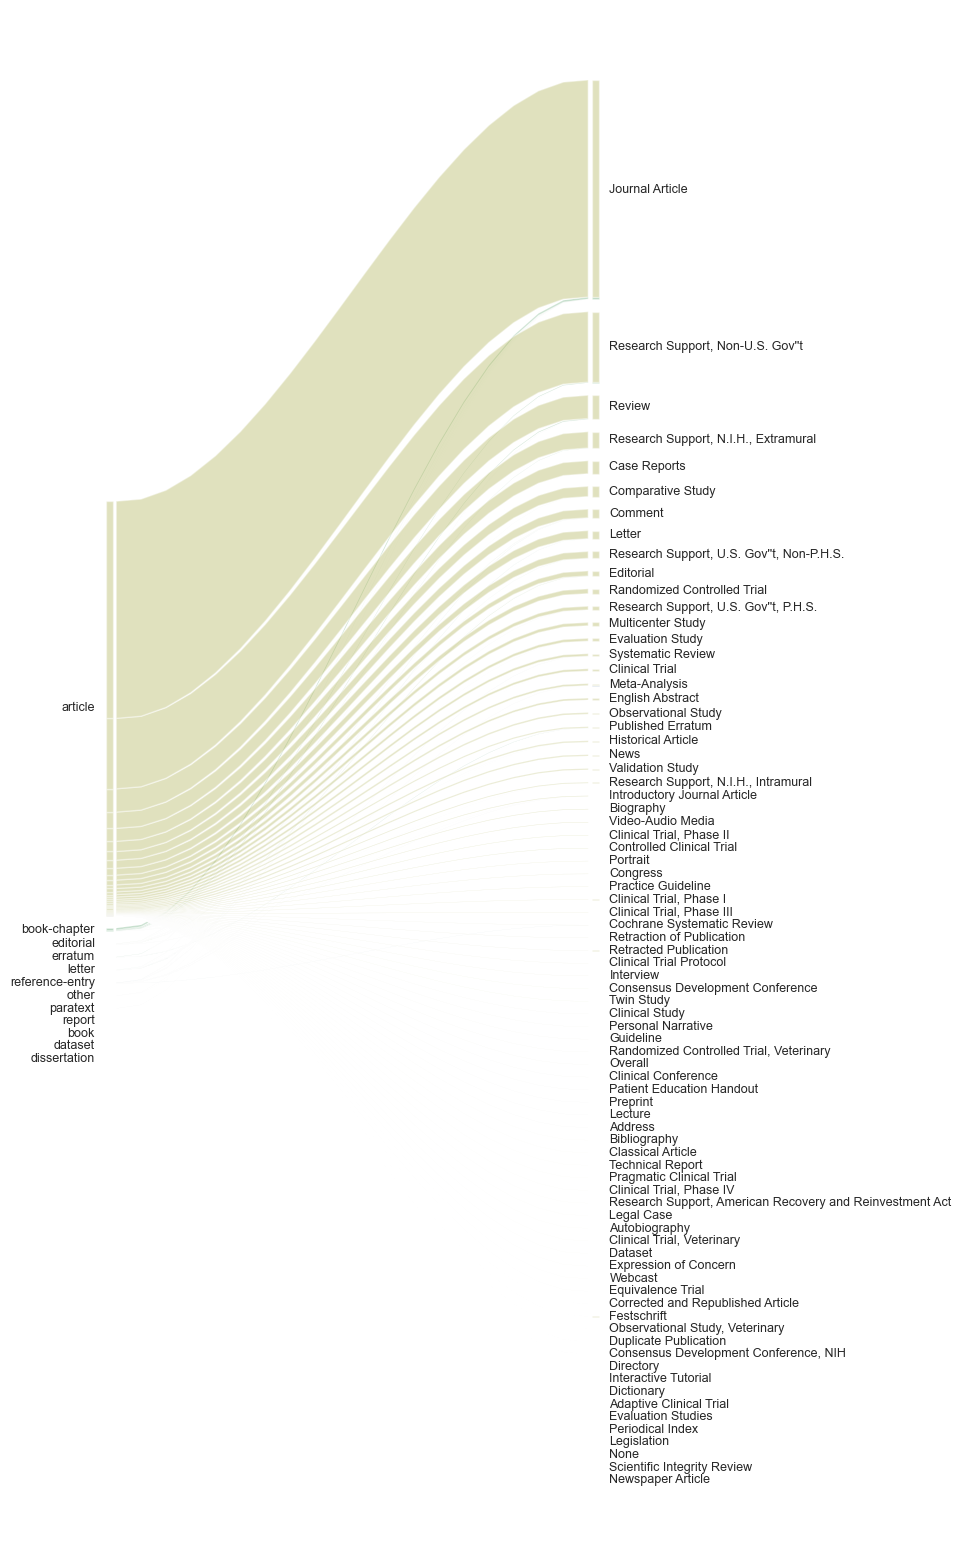

In [106]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(7,20)
plt.show()

In [11]:
openalex_pm_pubtypes_editorial = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_pubtypes, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                WHERE ptype IN ("Editorial", "Letter", "News")
                GROUP BY oalex_type, pm_pubtypes
                ORDER BY n DESC
                """).to_dataframe()

In [12]:
openalex_pm_pubtypes_editorial

,oalex_type,pm_pubtypes,n
0,article,Letter,663393
1,article,Editorial,412509
2,article,News,107408
3,editorial,Editorial,27120
4,letter,Letter,14357
5,book-chapter,Editorial,869
6,erratum,Letter,114
7,reference-entry,Editorial,105
8,letter,Editorial,101
9,editorial,Letter,74


In [14]:
openalex_pm_pubtypes_paratext = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_pubtypes, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                WHERE oalex.type = "paratext"
                GROUP BY oalex_type, pm_pubtypes
                ORDER BY n DESC
                """).to_dataframe()

In [15]:
openalex_pm_pubtypes_paratext

,oalex_type,pm_pubtypes,n
0,paratext,Journal Article,1249
1,paratext,Case Reports,291
2,paratext,Review,109
3,paratext,Comparative Study,81
4,paratext,"Research Support, Non-U.S. Gov''t",56
5,paratext,Letter,39
6,paratext,Congress,36
7,paratext,Overall,32
8,paratext,Editorial,28
9,paratext,Comment,20


In [13]:
openalex_pm_pubtypes_publisher = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_pubtypes, s.host_organization_name AS publisher, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                GROUP BY oalex_type, pm_pubtypes, publisher
                ORDER BY n DESC
                """).to_dataframe()

In [14]:
openalex_pm_pubtypes_publisher

,oalex_type,pm_pubtypes,publisher,n
0,article,Journal Article,Elsevier BV,4041606
1,article,"Research Support, Non-U.S. Gov''t",Elsevier BV,1494978
2,article,Journal Article,Springer Science+Business Media,1371489
3,article,Journal Article,Wiley-Blackwell,1211998
4,article,Journal Article,Wiley,687634
...,...,...,...,...
22325,erratum,Published Erratum,Royal Society of Chemistry,1
22326,letter,Comparative Study,American Association of Neurological Surgeons,1
22327,article,Retraction of Publication,Korean Society for the Study of Obesity,1
22328,article,Editorial,Viguera Publishers,1


In [6]:
openalex_pm_pubtypes_publisher_editorial = client.query(f"""
                SELECT oalex.type AS oalex_type, ptype AS pm_pubtypes, s.host_organization_name AS publisher, COUNT(DISTINCT(oalex.doi)) AS n
                FROM `subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022` AS pm
                JOIN `subugoe-collaborative.openalex.works` AS oalex
                ON LOWER(oalex.doi) = LOWER(pm.doi)
                LEFT JOIN `subugoe-collaborative.openalex.sources` AS s
                ON LOWER(primary_location.source.id) = LOWER(s.id)
                WHERE ptype IN ("Editorial", "Letter", "News")
                GROUP BY oalex_type, pm_pubtypes, publisher
                ORDER BY n DESC
                """).to_dataframe()

In [7]:
openalex_pm_pubtypes_publisher_editorial

,oalex_type,pm_pubtypes,publisher,n
0,article,Letter,Elsevier BV,218096
1,article,Editorial,Elsevier BV,123312
2,article,Letter,Wiley-Blackwell,80691
3,article,Letter,Lippincott Williams & Wilkins,48309
4,article,Letter,Springer Science+Business Media,44269
...,...,...,...,...
1826,article,Letter,Institution of Engineering and Technology,1
1827,letter,Letter,OMICS Publishing Group,1
1828,article,Editorial,Cellular and Molecular Biology Association,1
1829,article,Letter,Medical Journals Sweden AB,1


In [11]:
s2_pubtypes = client.query(f"""
                            SELECT s2_pubtypes, COUNT(DISTINCT(externalids.DOI)) AS n
                            FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                            GROUP BY s2_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [12]:
s2_pubtypes

,s2_pubtypes,n
0,JournalArticle,34241462
1,Review,10618917
2,Conference,3874850
3,Study,1876313
4,CaseReport,1524572
5,LettersAndComments,1298025
6,Editorial,574586
7,ClinicalTrial,460394
8,Book,313607
9,News,148077


In [5]:
s2_oalex_pubtypes = client.query(f"""
                                  SELECT type AS oalex_type, s2_pubtypes, COUNT(DISTINCT(doi)) AS n
                                  FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                  JOIN {openalex} AS oalex
                                  ON LOWER(oalex.doi) = LOWER(s2.externalids.DOI)
                                  GROUP BY oalex_type, s2_pubtypes
                                  ORDER BY oalex_type, s2_pubtypes
                                  """).to_dataframe()

In [34]:
d = {}
for row in s2_oalex_pubtypes.to_dict('records'):
    oalex_type = row['oalex_type']
    s2_pubtype = row['s2_pubtypes']
    n = row['n']

    dd = {}
    dd[s2_pubtype] = n
    
    if row['oalex_type'] in d:
        d[oalex_type].update(dd)
    else:
        d[oalex_type] = dd

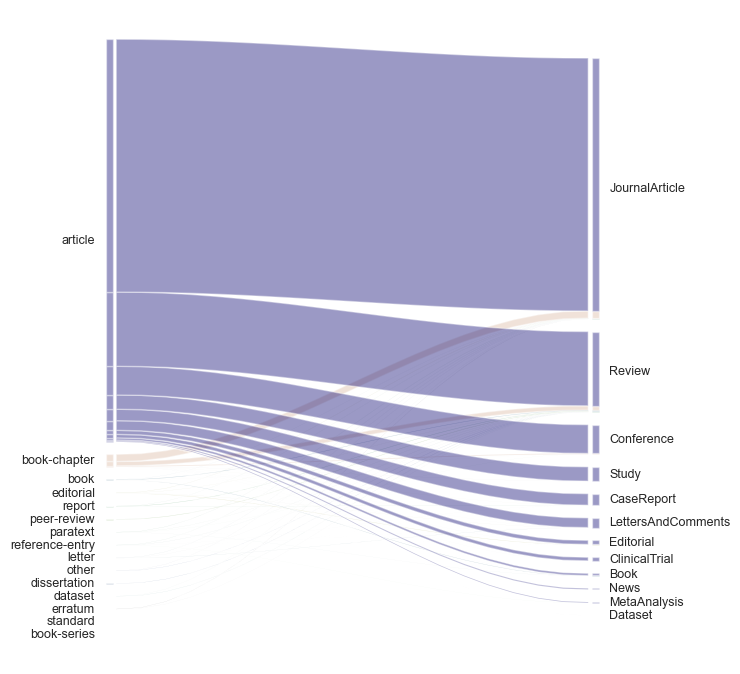

In [49]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(7,8.5)
plt.show()

In [107]:
s2_pm_pubtypes = client.query(f"""
                               SELECT ptype AS pm_type, s2_pubtypes, COUNT(DISTINCT(doi)) AS n
                               FROM {s2} AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                               JOIN {pm} AS pm
                               ON LOWER(pm.doi) = LOWER(s2.externalids.DOI)
                               GROUP BY pm_type, s2_pubtypes
                               ORDER BY pm_type, s2_pubtypes
                               """).to_dataframe()

In [108]:
s2_pm_pubtypes

,pm_type,s2_pubtypes,n
0,None,JournalArticle,1
1,None,LettersAndComments,1
2,None,Review,2
3,Adaptive Clinical Trial,ClinicalTrial,2
4,Adaptive Clinical Trial,JournalArticle,36
...,...,...,...
660,Webcast,LettersAndComments,3
661,Webcast,MetaAnalysis,11
662,Webcast,News,2
663,Webcast,Review,166


In [109]:
s2_pm_pubtypes.fillna('None', inplace=True)

In [113]:
d = {}
for row in s2_pm_pubtypes.to_dict('records'):
    s2_type = row['s2_pubtypes']
    pm_pubtype = row['pm_type']
    n = row['n']

    dd = {}
    dd[pm_pubtype] = n
    
    if row['s2_pubtypes'] in d:
        d[s2_type].update(dd)
    else:
        d[s2_type] = dd

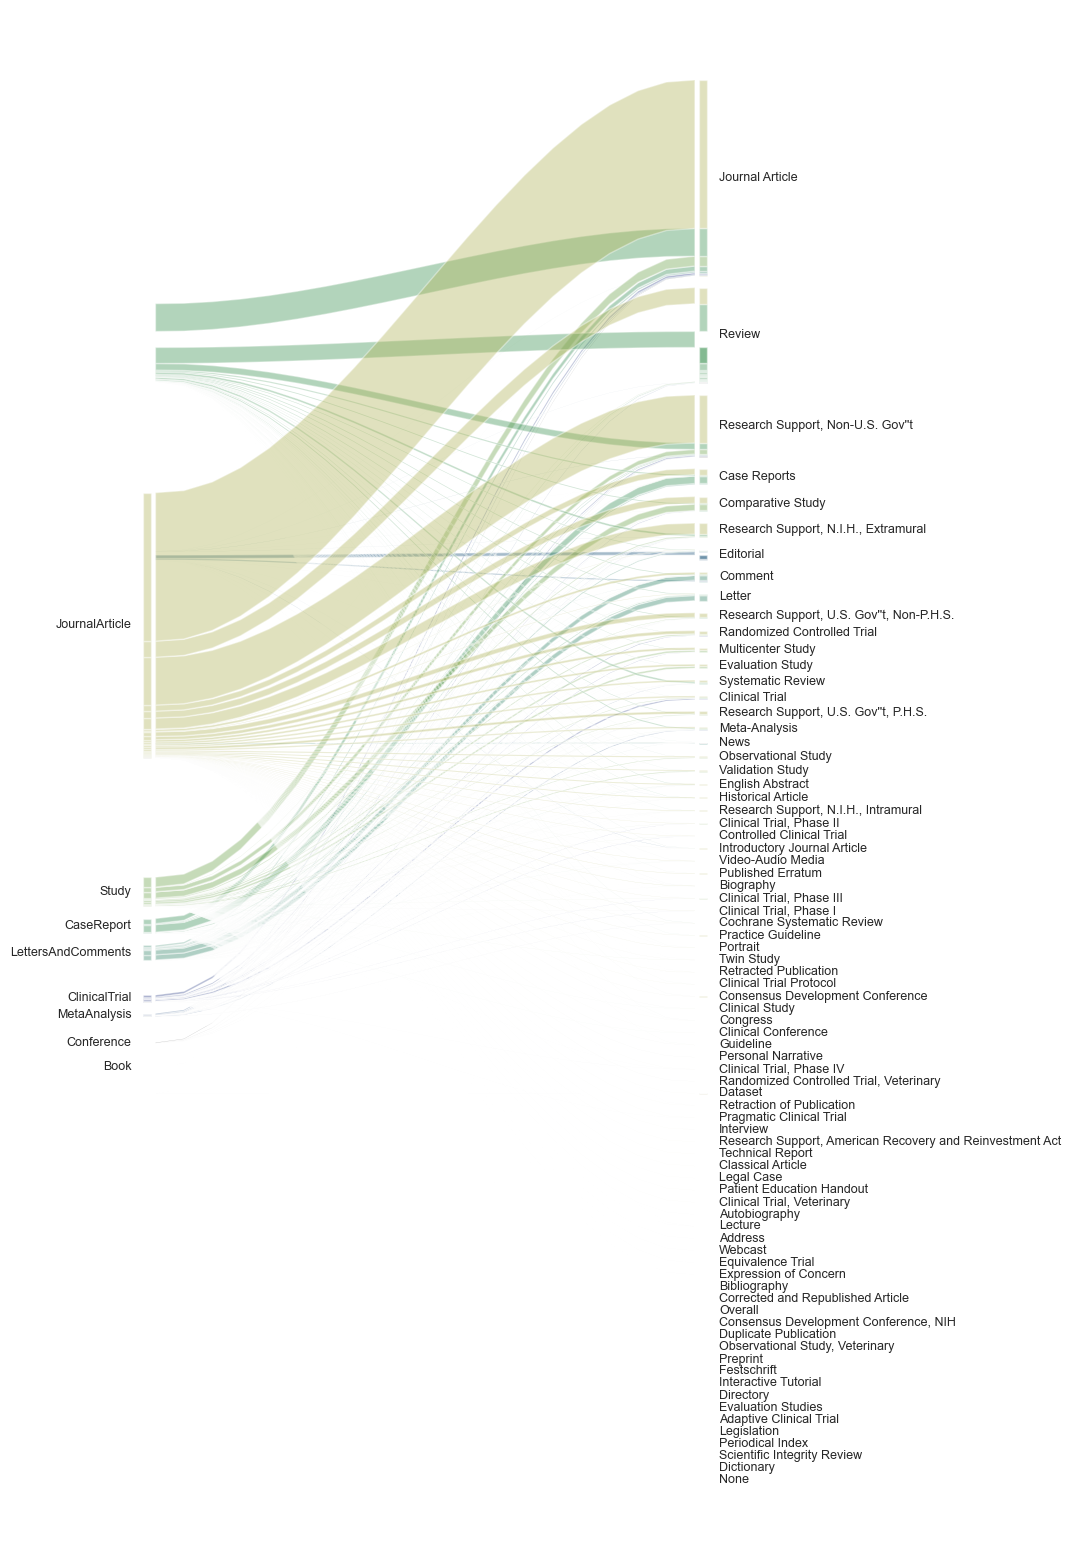

In [122]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(8,20)
plt.show()